In [18]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel
from transformers import AutoTokenizer, CLIPTextModelWithProjection
from transformers import AutoProcessor, CLIPVisionModelWithProjection
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

from sklearn.manifold import TSNE
import scipy.stats as st 
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import numpy as np
import pickle
from sklearn.metrics.pairwise import pairwise_distances_argmin, pairwise_distances

import graph_structure as gs

In [2]:
pickle_file_path = "../data/embeds_cifar100.pkl"
data = pickle.load(open(pickle_file_path, 'rb'))
image_embeds = data["image_embeds"]
y_real = data["y_real"]
text_embeds = data["text_embeds"]
templates = data["templates"]
texts = data["texts"]
classes = data["classes"]


In [3]:
def class_rep(X, y):
    X_ = []
    y_ = []
    for c in set(list(y)):
        X_.append(np.mean (X[y==c], axis=0))
        y_.append(c)
    return np.array(X_), np.array(y_).reshape( (-1, 1))



In [4]:
# Plot of a real-life case
X, y = class_rep(np.squeeze(image_embeds), np.squeeze(y_real))
print(X.shape)
dgs = []
labels = []
ks = list(range(1, len(y)))
for i in tqdm(range(len(templates))):
    labels.append(templates[i])
    dg = []
    Z = text_embeds[i::len(templates),:]
    for idx, k in enumerate(ks):
        sg = gs.mean_neighborhood_similarity_from_points(X, Z, k)
        dg.append(sg)
      
    dgs.append(dg)        

(100, 512)


  0%|          | 0/18 [00:00<?, ?it/s]

100%|██████████| 18/18 [00:06<00:00,  2.64it/s]


In [5]:
M = 100-1
n = ks[:-2]
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

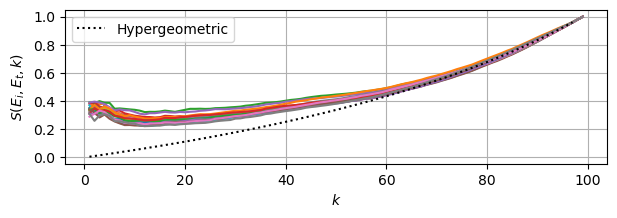

In [6]:
plt.figure(figsize=(7,2))

plt.plot(ks, np.array(dgs).T, '-')
#plt.scatter( ks[np.argmax(res)], np.max(res), label='$S_g(A,B)$', c='r')
#plt.title(f'$d$ for different $k$. samples={n_samples}, SNR={np.round(SNR,2)}dB' )
plt.xlabel('$k$')
plt.ylabel('$S(E_i, E_t, k)$')
#plt.legend(ncol=4)
plt.plot(n, js, 'k:', label='Hypergeometric')
plt.legend()
#plt.xlim([0,5])
#plt.ylim([0, 1])
#plt.semilogx()
#plt.semilogy()
a = 0.2
plt.yticks(np.arange(0,1+a, a))
plt.grid()
plt.savefig('s_embeddings_k.pdf', bbox_inches='tight')
plt.show()

In [7]:

X, y = class_rep(np.squeeze(image_embeds), np.squeeze(y_real))
k = 20
acc = []
jdist = []
for i in range(len(templates)):
    Z = text_embeds[i::len(templates),:]
    cos_sim = pairwise_distances_argmin(np.squeeze(image_embeds), Z, metric="cosine")
    acc.append(accuracy_score(y_real, cos_sim))
    #dg = mean_neighborhoood_distance(X, Z, 5)
    dg = gs.mean_neighborhood_similarity_from_points(X, Z, k)
    jdist.append(dg)

print(acc)
print(jdist)
print(st.pearsonr(jdist, acc))
print(st.spearmanr(jdist, acc))

[0.6448, 0.6384, 0.6354, 0.6457, 0.641, 0.638, 0.6403, 0.6319, 0.6233, 0.6323, 0.6202, 0.6162, 0.6299, 0.6324, 0.6315, 0.6277, 0.6342, 0.5903]
[0.2775364167452658, 0.28797377721878925, 0.3384027271286685, 0.2900682201709485, 0.32123403024253916, 0.27279738332014325, 0.27291978711587683, 0.2735261671090265, 0.2564570138181339, 0.24294525564608926, 0.2636566179212909, 0.29220133797877024, 0.27023757139890625, 0.28848354646558516, 0.25937491019685865, 0.251801868364182, 0.24864251127218737, 0.2380389232247504]
PearsonRResult(statistic=0.44959658184356716, pvalue=0.061216299375928575)
SignificanceResult(statistic=0.5149638802889577, pvalue=0.028748754882630335)


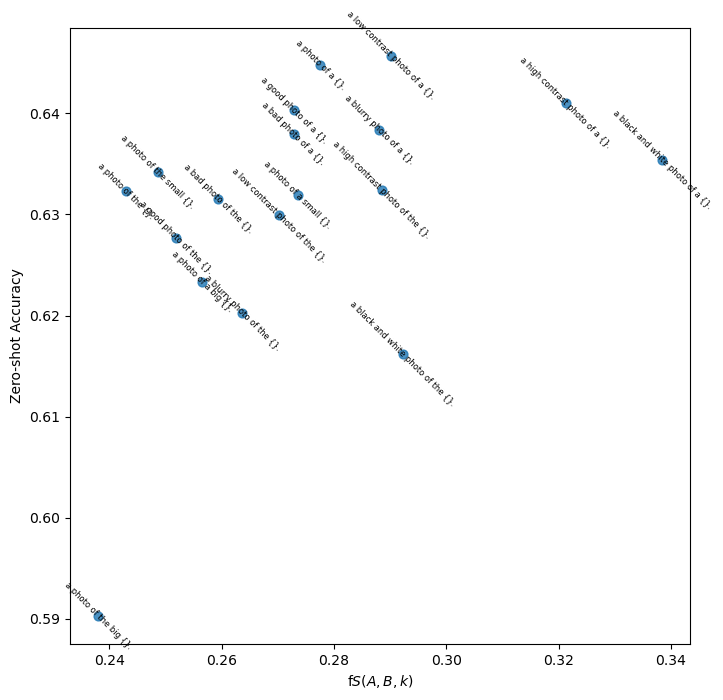

In [8]:
plt.figure(figsize=(8,8))
plt.scatter(jdist, acc, s=40, alpha=0.8)
for i in range(len(templates)):
    plt.text(jdist[i], acc[i], templates[i], fontsize=6, ha='center', va='center', rotation=-45)
    #plt.text(jdist[i], acc[i]-0.01, ks[i], fontsize=8, ha='center', va='top')
plt.xlabel('f$S(A,B,{k})$')
plt.ylabel('Zero-shot Accuracy')
plt.savefig('zeroshot_sg.pdf', bbox_inches='tight')
plt.show()

# With weird templates

In [9]:
# templates_ = [
#     'No, Luke. I AM your {}.',
#     'Not a {}.',
#     'The sound of a {}.',
#     'Feel the power of a {}.',
#     'Born to be {}.',
#     'Hasta la vista, {}!',
#     'I am feeling supersonic, give me {} and tonic.',
#     'LOL {} is SO random!',
#     'Perhaps {} could help us save Robin from The Joker.',
#     'The wheels on the {} go round and round.',
#     'We all live in a yellow {}',
#     '{}.',
#     'I like {}',
#     'I cant find the {} here.',
#     'I can find the {} here.',
#     'Most {} are good-looking.',
#     'You are a {}, Harry!',
#     'AND MY {}!',
#     'We must take the {} to Mordor!',
# ]

templates_ = [
    'Luke. I AM your {}.',
    'The sound of a {}.',
    'Feel the power of a {}.',
    'Born to be {}.',
    'I am feeling supersonic, give me {} and tonic.',
    'LOL {} is SO random!',
    'Perhaps {} could help us save Robin from The Joker.',
    'The wheels on the {} go round and round.',
    'We all live in a yellow {}',
    '{}.',
    'I like {}',
    'I can find the {} here.',
    'Most {} are good-looking.',
    'You are a {}, Harry!',
    'AND MY {}!',
    'We must take the {} to Mordor!',
]

# templates_ = [
#     'This is a {}.',
#     'This is not a {}.'
    
# ]

# templates_ = ['not ' + s for s in templates]

templates_neg = [
    'Luke. I am NOT your {}.',
    'Not the sound of a {}.',
    'Don\'t feel the power of a {}.',
    'Not born to be {}.',
    'I am not feeling supersonic, do not give me {} and tonic.',
    'LOL {} is SO not random!',
    'Perhaps {} could not help us save Robin from The Joker.',
    'The wheels on the {} do not go round and round.',
    'We do not live in a yellow {}',
    'Not {}.',
    'I do not like {}',
    'I cannot find the {} here.',
    'Most {} are bad-looking.',
    'You are not a {}, Harry!',
    'NOT MY {}!',
    'We must not take the {} to Mordor!',
]

n_new = len(templates_)
#templates_ = templates_ + templates_neg


texts_ = []
templates_ += templates
for c in classes:    
    for t in templates_:
        texts_.append(t.format(c))



In [10]:
# Get text embeddings
model = CLIPTextModelWithProjection.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
inputs = tokenizer(texts_, padding=True, return_tensors="pt")
outputs = model(**inputs)
text_embeds_ = outputs.text_embeds.detach().numpy()

In [11]:
# Plot of a real-life case
X, y = class_rep(np.squeeze(image_embeds), np.squeeze(y_real))
print(X.shape)
dgs = []
labels = []
ks = list(range(1, len(y)))
for i in tqdm(range(len(templates_))):
    labels.append(templates_[i])
    dg = []
    Z = text_embeds_[i::len(templates_),:]
    for idx, k in enumerate(ks):
        sg = gs.mean_neighborhood_similarity_from_points(X, Z, k)
        dg.append(sg)
      
    dgs.append(dg)        

(100, 512)


  0%|          | 0/34 [00:00<?, ?it/s]

100%|██████████| 34/34 [00:11<00:00,  2.89it/s]


In [12]:
M = 100-1
n=ks
N = n
intersection = st.hypergeom.mean(M,n,N)
union = 2 * np.array(n) - np.array(intersection)
js = intersection/union

/home/tiago/miniconda3/envs/graph/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:654: RuntimeWarning: divide by zero encountered in divide
  g2 /= n * N * (M - N) * m * (M - 2.) * (M - 3.)
/home/tiago/miniconda3/envs/graph/lib/python3.11/site-packages/scipy/stats/_discrete_distns.py:658: RuntimeWarning: divide by zero encountered in _hypergeom_skewness
  _boost._hypergeom_skewness(n, N, M),


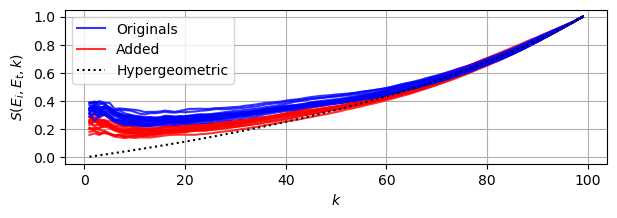

In [13]:
plt.figure(figsize=(7,2))
colors = [(1,0,0,1)] * (len(templates_)-len(templates)) + [(0,0,1,1)] * len(templates_)
#labels = ['Negatives'] * len(templates_neg) + ['Positives'] * len(templates_neg)

for i in range(len(dgs)):
    if i==0:
        label='Added'
    elif i==len(templates_)-len(templates)+1:
        label='Originals'
    else:
        label = None
    plt.plot(ks, dgs[i], '-', c=colors[i], alpha=.8, label=label)
#plt.scatter( ks[np.argmax(res)], np.max(res), label='$S_g(A,B)$', c='r')
#plt.title(f'$d$ for different $k$. samples={n_samples}, SNR={np.round(SNR,2)}dB' )
plt.xlabel('$k$')
plt.ylabel('$S(E_i, E_t, k)$')
#plt.legend(ncol=4)

plt.plot(n, js, 'k:', label='Hypergeometric' )
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0, 2]  # Ordem desejada para as legendas (nesse caso, trocando a ordem)
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
#plt.xlim([0,5])
#plt.ylim([0, 1])
#plt.semilogx()
#plt.semilogy()
a = 0.2
plt.yticks(np.arange(0,1+a, a))
plt.grid()
plt.savefig('s_embeddings_k_with_weird.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_3522392/657015387.py:14: RuntimeWarning: invalid value encountered in divide
  yaxis = (np.array(dgs[i])-np.array(js))/(1-np.array(js))


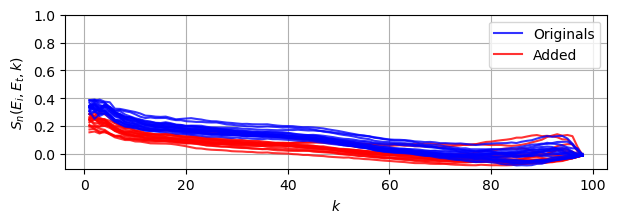

In [14]:
# This is scratch

plt.figure(figsize=(7,2))
colors = [(1,0,0,1)] * (len(templates_)-len(templates)) + [(0,0,1,1)] * len(templates_)
#labels = ['Negatives'] * len(templates_neg) + ['Positives'] * len(templates_neg)

for i in range(len(dgs)):
    if i==0:
        label='Added'
    elif i==len(templates_)-len(templates)+1:
        label='Originals'
    else:
        label = None
    yaxis = (np.array(dgs[i])-np.array(js))/(1-np.array(js))
    plt.plot(ks, yaxis, '-', c=colors[i], alpha=.8, label=label)
#plt.scatter( ks[np.argmax(res)], np.max(res), label='$S_g(A,B)$', c='r')
#plt.title(f'$d$ for different $k$. samples={n_samples}, SNR={np.round(SNR,2)}dB' )
plt.xlabel('$k$')
plt.ylabel('$S_n(E_i, E_t, k)$')
#plt.legend(ncol=4)

#plt.plot(n, js, 'k:', label='Hypergeometric' )
handles, labels = plt.gca().get_legend_handles_labels()
order = [1, 0]  # Ordem desejada para as legendas (nesse caso, trocando a ordem)
plt.legend([handles[idx] for idx in order], [labels[idx] for idx in order])
#plt.xlim([0,5])
#plt.ylim([0, 1])
#plt.semilogx()
#plt.semilogy()
a = 0.2
plt.yticks(np.arange(0,1+a, a))
plt.grid()
plt.savefig('s_embeddings_k_with_weird.pdf', bbox_inches='tight')
plt.show()

In [15]:
X, y = class_rep(np.squeeze(image_embeds), np.squeeze(y_real))
k = 5
acc = []
jdist = []
for i in range(len(templates_)):
    Z = text_embeds_[i::len(templates_),:]
    cos_sim = pairwise_distances_argmin(np.squeeze(image_embeds), Z, metric="cosine")
    acc.append(accuracy_score(y_real, cos_sim))
    dg = gs.mean_neighborhood_similarity_from_points(X, Z, k)
    jdist.append(dg)

print(st.pearsonr(jdist, acc))
print(st.spearmanr(jdist, acc))

PearsonRResult(statistic=0.8682242420421618, pvalue=2.9073101757165247e-11)
SignificanceResult(statistic=0.9074102368220015, pvalue=1.3727197659867434e-13)


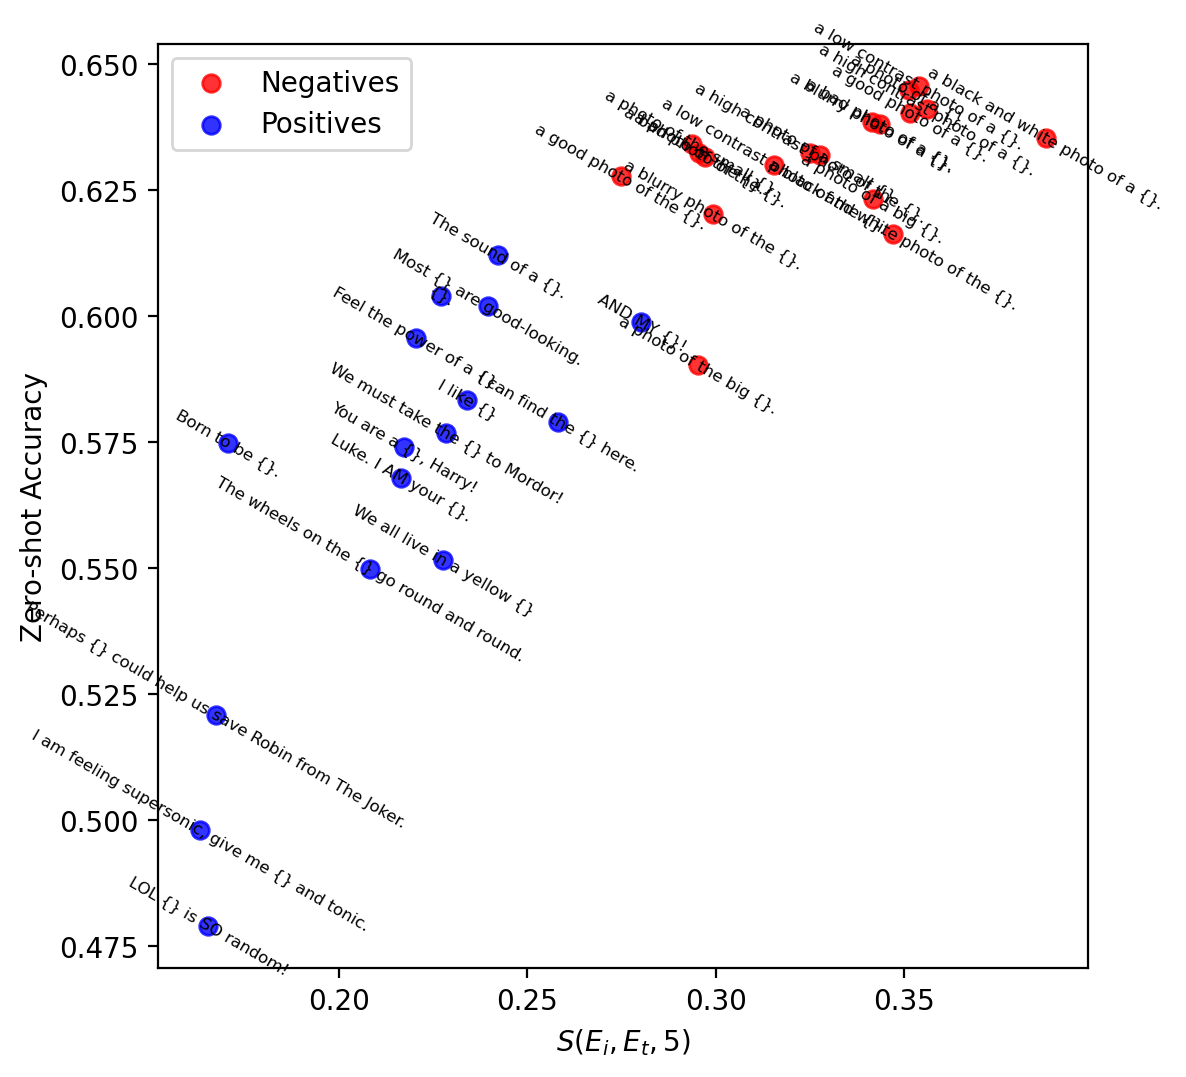

In [20]:
plt.figure(figsize=(6,6))
jdist=np.array(jdist)
acc=np.array(acc)
plt.scatter(jdist[n_new:], acc[n_new:], s=40, alpha=0.8, c='r', label='Negatives')
plt.scatter(jdist[:n_new], acc[:n_new], s=40, alpha=0.8, c='b', label='Positives')
for i in range(len(templates_)):
    plt.text(jdist[i], acc[i], templates_[i], fontsize=6, ha='center', va='center', rotation=-30)
    #plt.text(jdist[i], acc[i]-0.01, ks[i], fontsize=8, ha='center', va='top')
# for i in range(n_new):
#     plt.arrow(x=jdist[i], y=acc[i], dx=jdist[n_new+i]-jdist[i], dy=acc[n_new+i]-acc[i],
#               length_includes_head=True, width=0.0002, head_width=0.002, head_length=0.003,
#               alpha=0.5)

plt.xlabel(f'$S(E_i,E_t,{k})$')
plt.ylabel('Zero-shot Accuracy')
plt.savefig('zeroshot_sg_dirty.pdf', bbox_inches='tight')
plt.legend()
plt.show()